# FIFA
This model is in progress...

## Description
This is a simple feed forward network for fifa dataset
    https://www.kaggle.com/karangadiya/fifa19

# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.mlp import FeedForwardNetwork
from utils.loading import Loader
from utils.trainer import Trainer

tf.enable_eager_execution()

# Constants

In [3]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 64
TRAIN_FRACTION = 0.8
WEIGHT_DECAY = 0.02
DROPOUT = 0.1

In [4]:
def compute_accuracy(logits, targets):
    losses = tf.losses.mean_squared_error(targets, logits)
    return tf.reduce_mean(losses)

def height_conversion(feet_and_inches):
    feet, inches = feet_and_inches.split("'")
    return float(feet) * 30.48 + float(inches) * 2.54

def weight_conversion(lbs):
    lbs = lbs[:-3]
    lbs = float(lbs)
    return lbs * 0.45359237

def compute_loss(targets, logits):
    losses = tf.losses.huber_loss(targets, logits)
    loss_value = tf.reduce_mean(losses)
    return loss_value

In [8]:
# Load data
loader = Loader('datasets/fifa.csv')

# Explore data
dd = loader.get_data()
print(list(dd))
print(dd.describe())
print("Size: {}".format(dd.shape))

# Create data split
features = ['Age', 'Height', 'Weight']
loader.apply('Height', height_conversion)
loader.apply('Weight', weight_conversion)
train_data, test_data = loader.get_data_split(features, TRAIN_FRACTION, target_name='Agility')

# Create model and optimizer
model = FeedForwardNetwork(units=[16, 16], use_sigmoid=False)
optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE)

# Train
trainer = Trainer(model, optimizer, train_data, test_data, compute_loss, compute_accuracy)
train_losses, train_accs, test_losses, test_accs = trainer.train(EPOCHS, BATCH_SIZE)

['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']
 

# Plot results

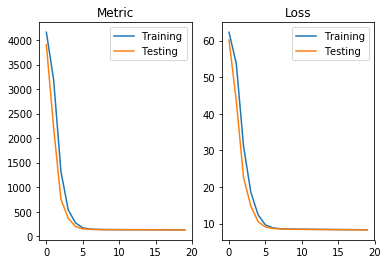

In [9]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(train_accs)
ax1.plot(test_accs)
ax1.set_title("Metric")
ax1.legend(['Training', 'Testing'])
ax2.plot(train_losses)
ax2.plot(test_losses)
ax2.set_title("Loss")
ax2.legend(['Training', 'Testing'])
plt.show()